In [34]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers, losses, regularizers

In [53]:
# Load the dataset
tar_path = r'C:\\Users\\admin\\Music\\gaurav'
dataset = tf.keras.utils.get_file("stack_overflow_16k", tar_path,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'C:\\Users\\admin\\Music\\gaurav')
train_dir = dataset_dir


In [54]:
os.listdir(dataset_dir)

['.ipynb_checkpoints',
 'DBMS-NOTES.pdf',
 'Human_Action_Recogntion_using_CNN_+_LSTM.ipynb',
 'main.ipynb',
 'README.md',
 'sql.pdf',
 'stack_overflow_16k.tar.gz',
 'Structured Query Language.pdf',
 'test',
 'train',
 'Untitled10.ipynb']

In [56]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)


['csharp', 'java', 'javascript', 'python']

In [57]:
sample_file = os.path.join(train_dir, 'python/118.txt')
with open(sample_file) as f:
  print(f.read())

"what's the correct way to change a value that is imported by other modules? i have my entry point script take a cli option argument using argsparser and that looks something like this:..    import some_module..    if __name__== ""__main__"":.        parser = argparse.argumentparser(description='nemo node.').        parser.add_argument('-t', '--test', dest='testing', action=""store_true"")..        # handle cli params and options.        # .......        some_module.run()...i want the -t option to change a parameter testing in a config script settings.py, since my some_module uses things like :..from settings import testing.if testing:.   # do some testing stuff...because of this testing is already imported into some_module by the time i handle the args, changes to settings.py can no longer have any effect on some_module..my answer is what's the correct practice in dealing with this:...import some_module inside the __main__ after the args have been parsed?.replace testing by settings.t

In [58]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [59]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split=0.2,
    subset='validation',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [60]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [61]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [62]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [63]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [64]:
max_size_vocab = 10000
max_sequence_length = 250
binary_vectorize_layer = layers.TextVectorization(
    max_tokens=max_size_vocab,
    output_mode='binary')

In [65]:
int_vectorize_layer = layers.TextVectorization(
  max_tokens=max_size_vocab,
  output_mode='int',
  output_sequence_length=max_sequence_length)

In [66]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [67]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [68]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)
int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

In [69]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [70]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)
int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)


In [71]:
from tensorflow.python.ops.control_flow_ops import from_control_flow_context_def
binary_model = tf.keras.Sequential([layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy']
)

history = binary_model.fit(
    binary_train_ds,validation_data=binary_val_ds, epochs=10
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.5425 - loss: 1.2379 - val_accuracy: 0.7719 - val_loss: 0.9156
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8208 - loss: 0.8197 - val_accuracy: 0.7975 - val_loss: 0.7520
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.8608 - loss: 0.6529 - val_accuracy: 0.8106 - val_loss: 0.6663
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.8822 - loss: 0.5533 - val_accuracy: 0.8194 - val_loss: 0.6128
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.9008 - loss: 0.4842 - val_accuracy: 0.8275 - val_loss: 0.5761
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9149 - loss: 0.4320 - val_accuracy: 0.8363 - val_loss: 0.5494
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.9256 - loss: 0.3904 - val_accuracy: 0.8375 - val_loss: 0.5292
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.9345 - loss: 0.3562 - 

In [72]:
# Creating a plot of accuracy and loss over time
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

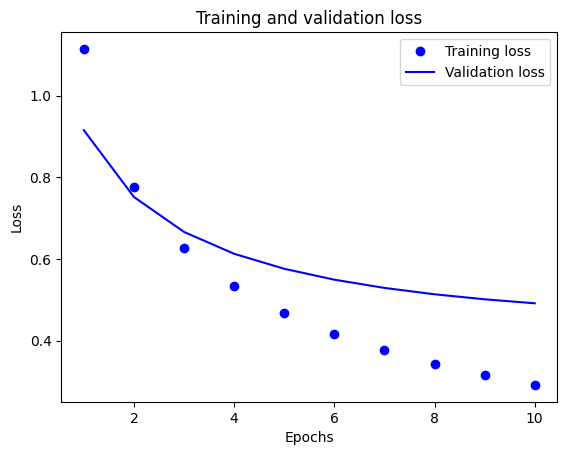

In [73]:

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

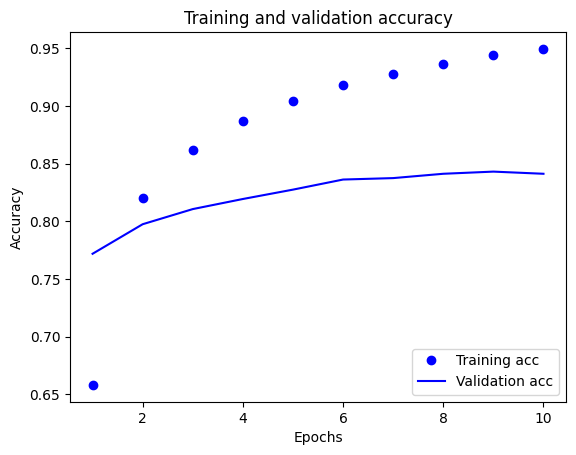

In [74]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [75]:
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 64, mask_zero=True),
    layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(num_labels)
    ])
  return model

In [76]:


int_model = create_model(vocab_size=max_size_vocab + 1, num_labels=4)
int_model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds,epochs=5)

Epoch 1/5


C:\Python\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3967 - loss: 1.2773 - val_accuracy: 0.6806 - val_loss: 0.7529
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7179 - loss: 0.6986 - val_accuracy: 0.7906 - val_loss: 0.5583
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8561 - loss: 0.4387 - val_accuracy: 0.8138 - val_loss: 0.4964
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9368 - loss: 0.2501 - val_accuracy: 0.8150 - val_loss: 0.5024
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9755 - loss: 0.1275 - val_accuracy: 0.8138 - val_loss: 0.5354


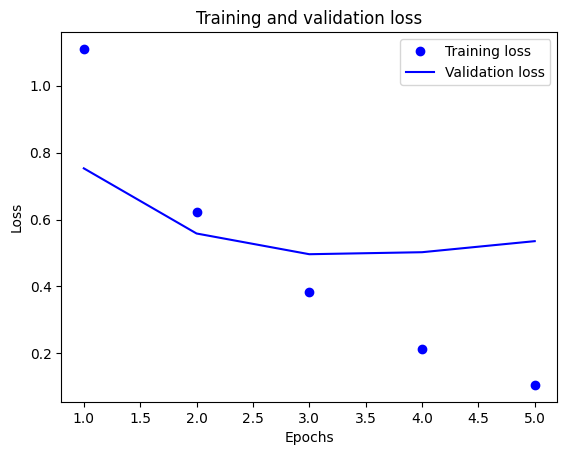

In [77]:
# Creating a plot of accuracy and loss over time
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

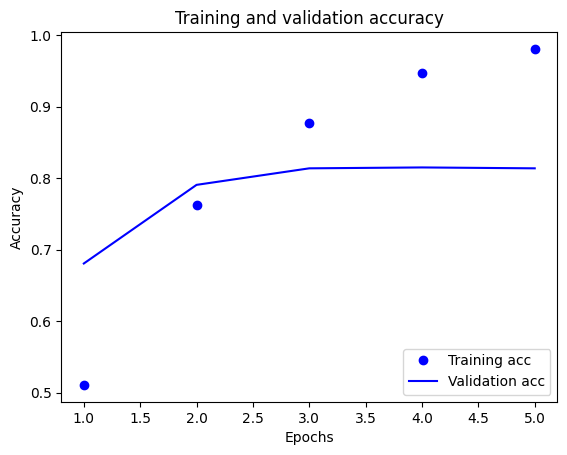

In [78]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [79]:
print("Linear model on binary vectorized data:")
print(binary_model.summary())

Linear model on binary vectorized data:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 4)                   │          40,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,014 (468.81 KB)

 Trainable params: 40,004 (156.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,010 (312.54 KB)

None


In [80]:
print("Conventional model on integer vectorized data:")
print(int_model.summary())

Conventional model on integer vectorized data:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 64)            │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,982,606 (7.56 MB)

 Trainable params: 660,868 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,321,738 (5.04 MB)

None


In [81]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy, = int_model.evaluate(int_test_ds)
print("Binary model accuracy : {:2.2%}".format(binary_accuracy))
print("Integer model accuracy : {:2.2%}".format(int_accuracy))

250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8197 - loss: 0.5112
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8082 - loss: 0.5305
Binary model accuracy : 81.45%
Integer model accuracy : 80.75%
